In [138]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (14, 8)

# Weighted sum of distributions

In [139]:
from sklearn.utils import check_random_state

class composed_rv(object):
    def __init__(self, components, weights):
        self.components = components
        self.weights = weights
        
    def pdf(self, x):
        return sum(p_c.pdf(x) * w for p_c, w in zip(self.components, self.weights))
    
    def rvs(self, n_samples=1, random_state=None):
        random_state = check_random_state(random_state)
        
        _, c = np.where(random_state.multinomial(1, self.weights, n_samples) == 1)
        samples = []

        for i in range(n_samples):
            samples.append(self.components[c[i]].rvs(random_state=random_state))
            
        if len(samples) == 1:
            return samples[0]
        else:
            return np.array(samples)

# Toy data

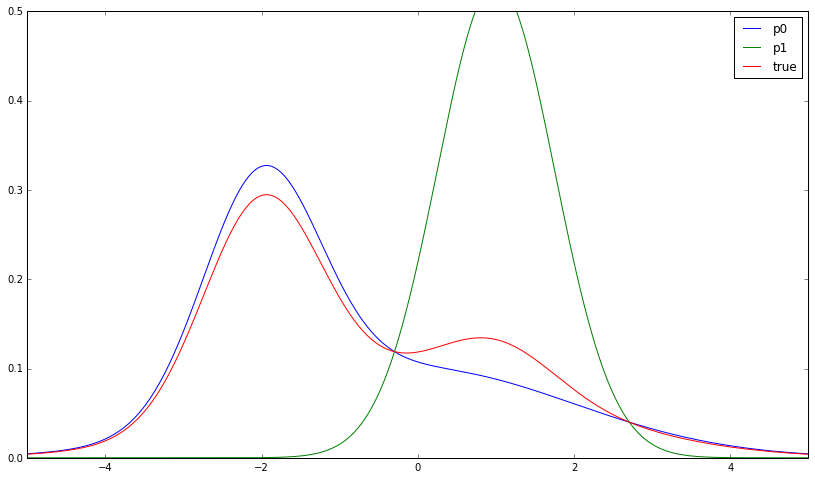

In [140]:
from scipy.stats import norm

# Define distributions
p0 = composed_rv([norm(loc=-2.0, scale=0.75), norm(loc=0.0, scale=2.0)], [0.5, 0.5])
p1 = norm(loc=1.0, scale=0.75)
theta = 0.1  # <= this is the parameter value we are looking for
true = composed_rv([p0, p1], [1 - theta, theta])

# Plot
x = np.linspace(-5, 5, num=1000)
plt.plot(x, p0.pdf(x), label="p0")
plt.plot(x, p1.pdf(x), label="p1")
plt.plot(x, true.pdf(x), label="true")
plt.xlim(-5, 5)
plt.ylim(0, 0.5)
plt.legend()
plt.show()

# $p_0$ and $p_1$ are known

Let assume that $p_0$ and $p_1$ are known. We want to solve $$\theta^* = \arg \max {\cal L}(\theta) = \prod_{i=0}^{N-1} \theta p_1(x_i) + (1-\theta) p_0(x_i),$$
for some known true data $\{x_i | i = 0, ..., N-1 \}$.

In [257]:
def likelihood(theta, p0, p1, X):  
    # Likelihood of X ~ theta*p0 + (1-theta)*p1, up to a constant factor
    X = np.array(X).ravel()
    l = np.sum(np.log(theta * p1.pdf(X) / p0.pdf(X) + (1 - theta)))
    return l 

def optimize(p0, p1, X_true):
    thetas = np.linspace(0., 1., num=100, endpoint=False)[1:]
    values = [likelihood(t, p0, p1, X_true) for t in thetas]
    best = np.argmax(values)
    return thetas[best], values[best], thetas, values

In [258]:
from sklearn.utils import check_random_state

solutions = []

for n in range(100):
    rng = check_random_state(n)
    X_true = true.rvs(5000, random_state=rng)
    best_theta, best_value, thetas, values = optimize(p0, p1, X_true)
    solutions.append(best_theta)

In [264]:
def plot_solutions(solutions):
    print("E[theta*] =", np.mean(solutions))
    print("Var[theta*] =", np.var(solutions))
    plt.hist(solutions, bins=20, range=(0.0, 0.2), normed=True, align="left")
    plt.xlim(0, 0.2)
    plt.show()

E[theta*] = 0.1
Var[theta*] = 6.2e-05


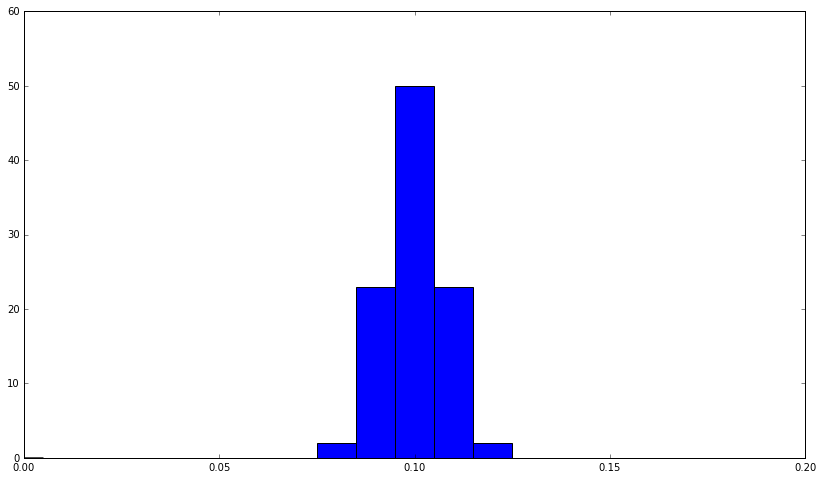

In [269]:
plot_solutions(solutions)

# $p_0$ and $p_1$ can be drawn from, use classifier score as proxy 

In [324]:
from sklearn.base import RegressorMixin

def likelihood_clf(theta, clf, X, log=True, eps=10e-7):
    if isinstance(clf, RegressorMixin):
        c = clf.predict(X)
    else:
        c = clf.predict_proba(X)[:, 1]
    c = np.clip(c, eps, 1.0 - eps)
    l = np.sum(np.log(theta * c / (1 - c) + (1 - theta)))
    return l if log else np.exp(l)

def optimize_clf(clf, X_true):
    thetas = np.linspace(0., 1., num=100, endpoint=False)[1:]
    values = [likelihood_clf(t, clf, X_true) for t in thetas]
    best = np.argmax(values)
    return thetas[best], values[best], thetas, values

In [303]:
from sklearn.utils import check_random_state
from sklearn.base import clone

def experiment(estimator, n_samples):
    n_samples //= 2
    solutions = []

    for n in range(50):
        rng = check_random_state(n)
        X_true = true.rvs(5000, random_state=rng).reshape(-1, 1)

        X_p0 = p0.rvs(n_samples, random_state=rng).reshape(-1, 1)
        X_p1 = p1.rvs(n_samples, random_state=rng).reshape(-1, 1)
        X = np.vstack((X_p0, X_p1))
        y = np.ones(len(X), dtype=np.int)
        y[:n_samples] = 0

        clf = clone(estimator)
        try:
            clf.set_params(random_state=rng)
        except:
            pass 
        clf.fit(X, y)

        best_theta, best_value, thetas, values = optimize_clf(clf, X_true)
        solutions.append(best_theta)
        
    return solutions

### Comparing `KNeighborsRegressor` of increasing accuracy

E[theta*] = 0.1456
Var[theta*] = 0.00077664


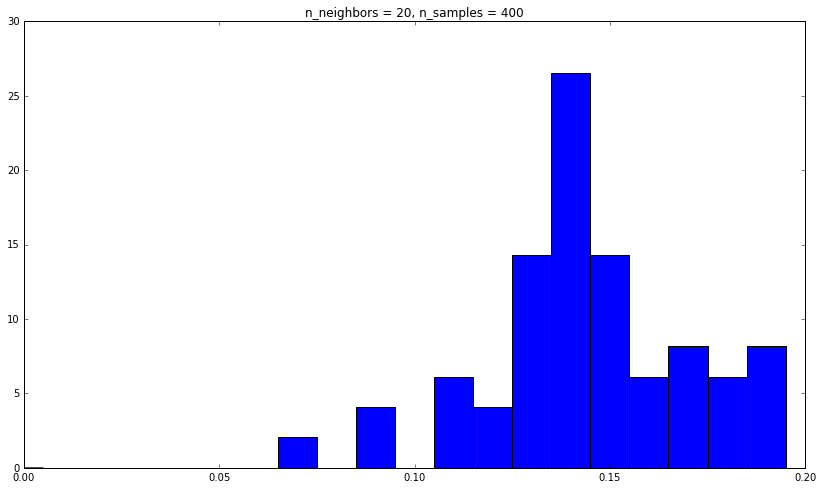

E[theta*] = 0.1302
Var[theta*] = 0.00055396


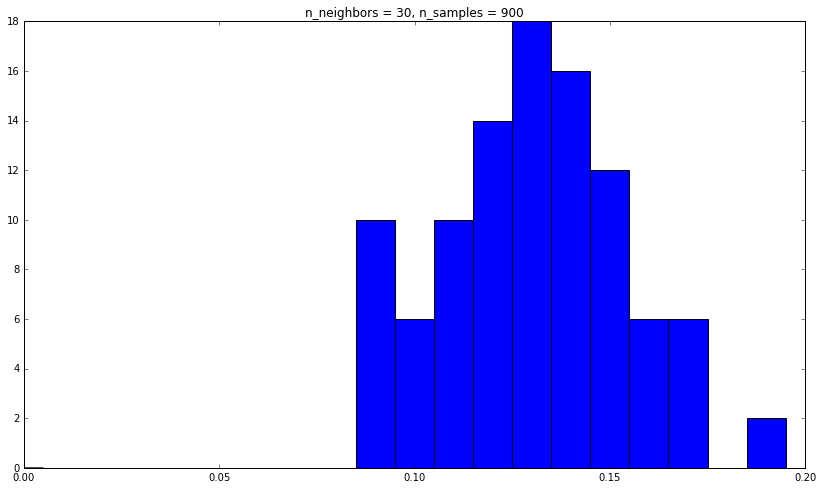

E[theta*] = 0.1238
Var[theta*] = 0.00029956


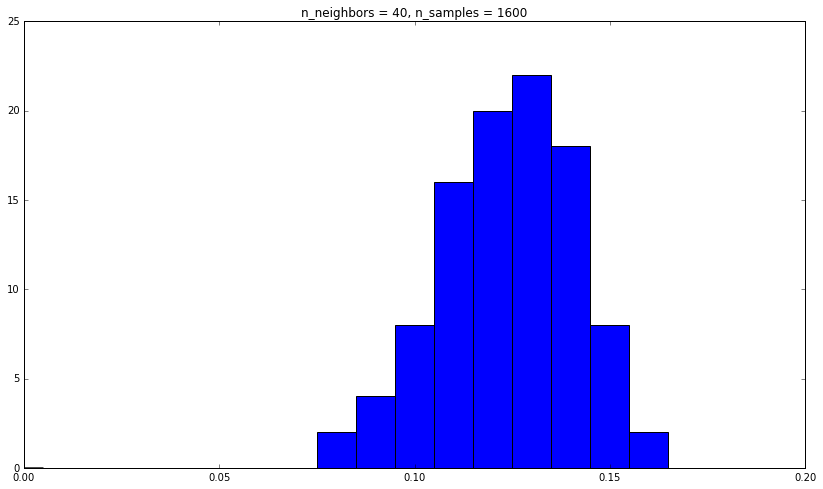

E[theta*] = 0.1168
Var[theta*] = 0.00023776


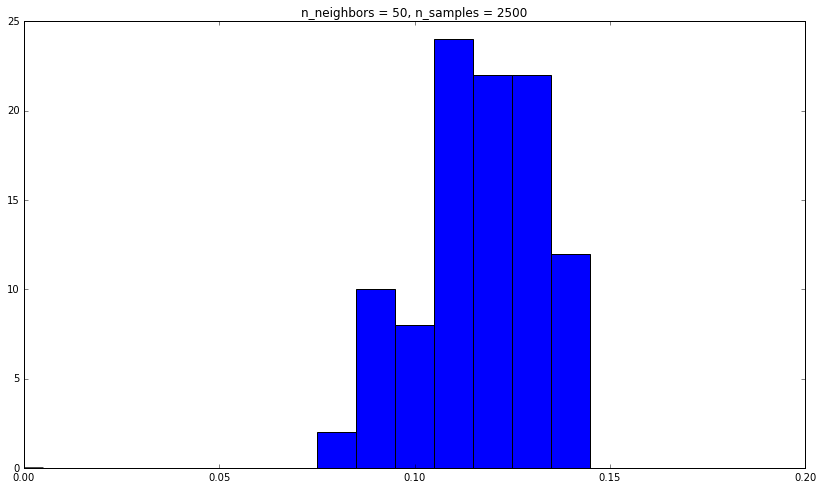

E[theta*] = 0.1086
Var[theta*] = 0.00011204


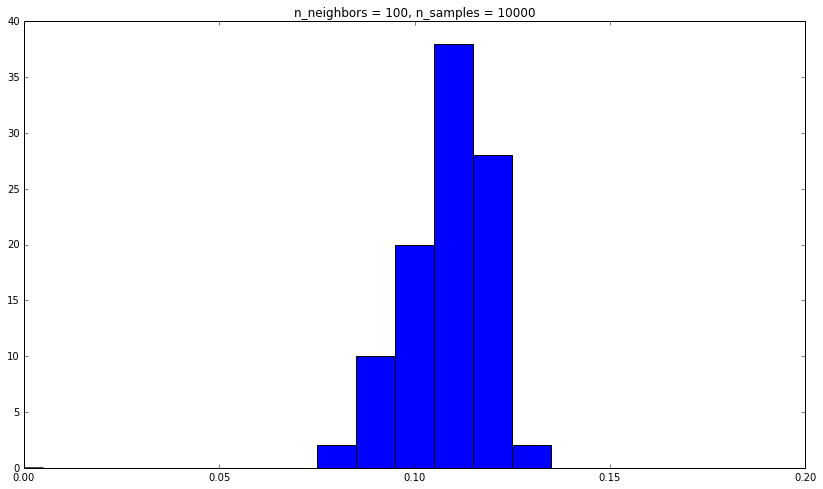

In [327]:
from sklearn.neighbors import KNeighborsRegressor

for n_neighbors, n_samples in [(20, 400), (30, 900), (40, 1600), (50, 2500), (100, 10000)]:
    solutions = experiment(KNeighborsRegressor(n_neighbors=n_neighbors), n_samples)
    plt.title("n_neighbors = %d, n_samples = %d" % (n_neighbors, n_samples))
    plot_solutions(solutions)

### Comparing `MLPRegressor` of increasing accuracy

E[theta*] = 0.0932
Var[theta*] = 0.00120976


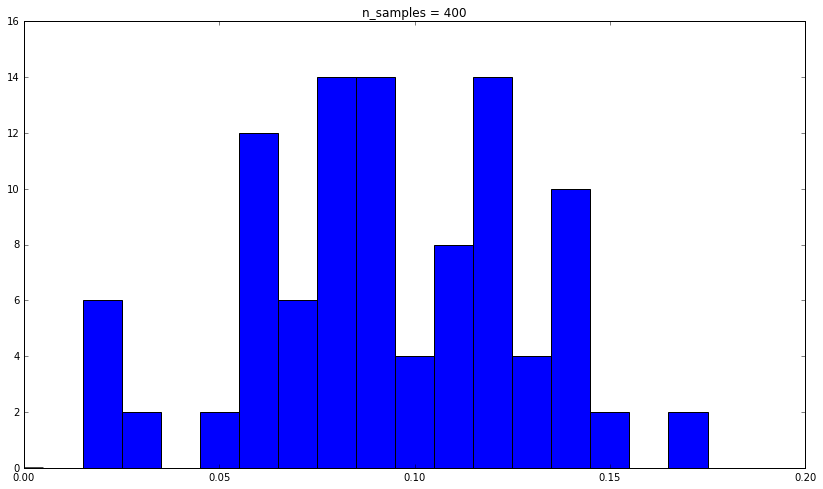

E[theta*] = 0.1014
Var[theta*] = 0.00095604


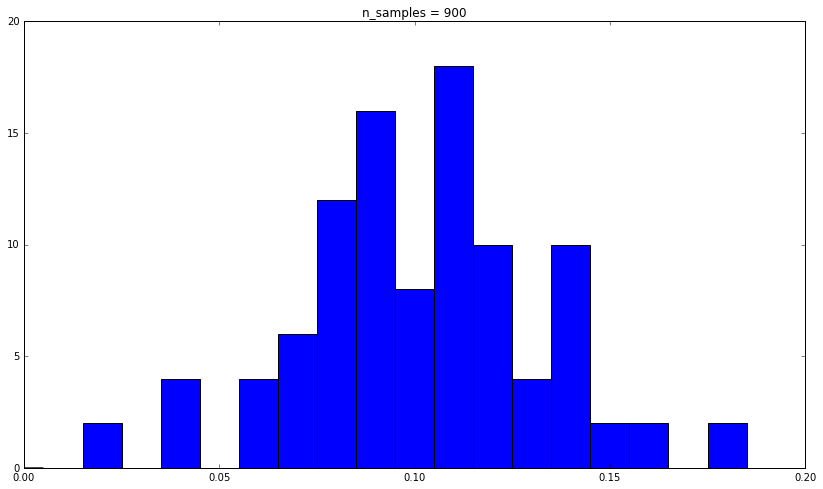

E[theta*] = 0.1036
Var[theta*] = 0.00064304


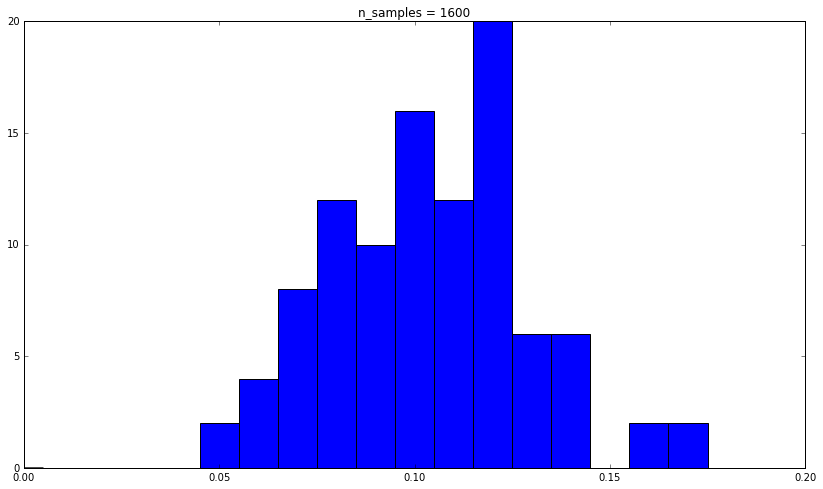

E[theta*] = 0.1086
Var[theta*] = 0.00112004


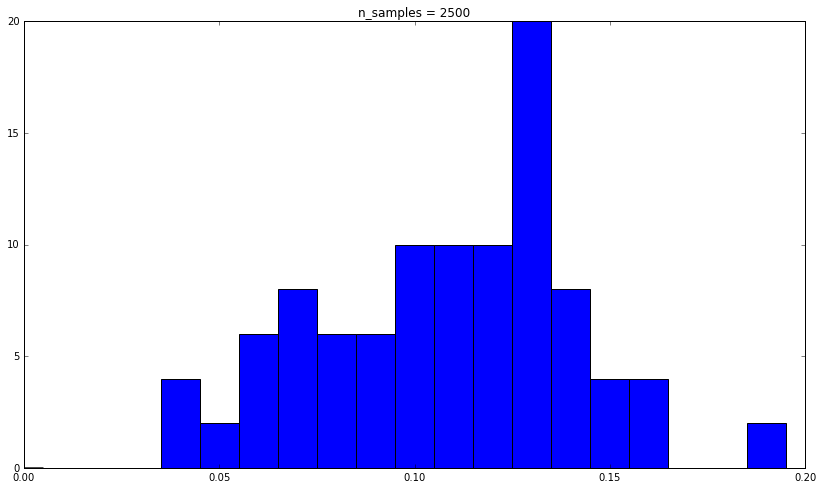

E[theta*] = 0.099
Var[theta*] = 0.001613


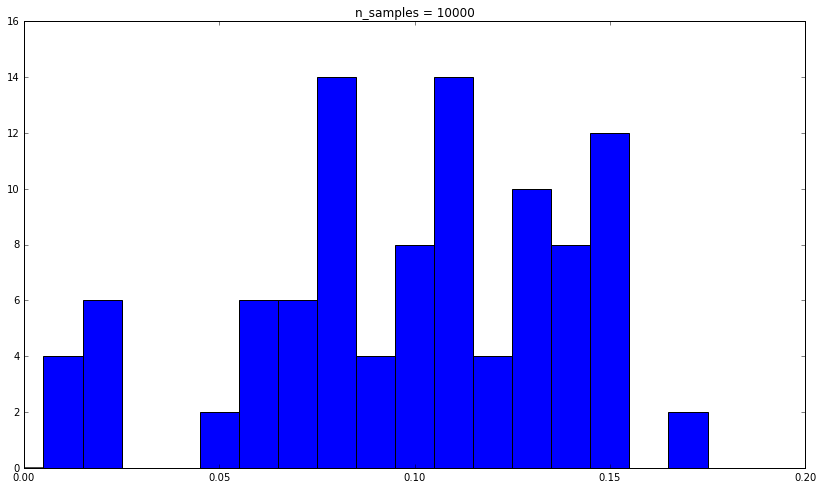

In [328]:
from sklearn.neural_network import MLPRegressor

for n_samples in [400, 900, 1600, 2500, 10000]:
    solutions = experiment(MLPRegressor(batch_size=100), n_samples)
    plt.title("n_samples = %d" % n_samples)
    plot_solutions(solutions)

Observations:
- for kNN, bias is strong but then decreases, variance is strong but then decreases
- for MLP, bias is low from the start, variance is strong and does not decrease with N

Since density ratio is 1:1 with the score, can we use a bias variance analysis to study the impact of the goodness of the regression?

# $p_0$ and $p_1$ can be drawn from, classifier is not well calibrated

In [326]:
# TODO: model p_0(r) and plug it in instead of using r directly, in case the classifier is not well calibrated
#       we should still be able to retrieve the correct ratio (Kyle's paper)